# Cheat Sheet - TensorFlow - Part 1
François Goujon

Content : Introduction to TensorFlow and Keras

### Table of Contents

* [Introduction](#intro)
    * [Tensor](#tensor)
    * [Variable](#var)
    * [AutoGrad](#autog)
    
* [Models](#models)
    * [Utils functions](#utils)
    * [TF.Module](#tfmod)
        * [Model](#tfm_mod)
        * [Training functions](#tfm_func)
        * [Train](#tfm_train)
    * [Keras](#keras)
        * [Model](#keras_mod)
        * [Train](#keras_train)
    * [Keras Sequential](#keras_seq)
        * [Model](#kseq_mod)
        * [Train](#kseq_train)

In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt

# Introduction <a class="anchor" id="intro"></a>
### Tensor  <a class="anchor" id="tensor"></a>
Same as np.array. Immuable. Works with +, * and @.

In [4]:
vec = tf.constant([0.35, 0.07, 0.78])
print(vec)
print(vec.numpy())

tf.Tensor([0.35 0.07 0.78], shape=(3,), dtype=float32)
[0.35 0.07 0.78]


### Variable <a class="anchor" id="var"></a>

A variable is based on a tensor but it is mutable.

In [5]:
var = tf.Variable(vec)
print(var)
var.assign_add([1, 1, 1])
print(var)
print(var.numpy())
var.assign([0, 0, 0])
print(var)

<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0.35, 0.07, 0.78], dtype=float32)>
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([1.35, 1.07, 1.78], dtype=float32)>
[1.35 1.07 1.78]
<tf.Variable 'Variable:0' shape=(3,) dtype=float32, numpy=array([0., 0., 0.], dtype=float32)>


### AutoGrad <a class="anchor" id="autog"></a>

In [6]:
# Auto Gradient : use tf.GradientTape() to watch variable (only variable by default)
x = tf.Variable(tf.linspace(-10, 10, 201)) # Variable
with tf.GradientTape() as tape: # Watch variable transformation to compute gradient
    y = tf.math.sin(x)

dy_dx = tape.gradient(y, x)

In [7]:
# Same than previous with tensor
x_t = tf.linspace(-10, 10, 201) # Tensor
with tf.GradientTape() as tape_t: # Watch variable transformation to compute gradient
    tape_t.watch(x_t) # Tensors are not watched by default, .watch to watch a tensor
    y_t = tf.math.sin(x_t)

dy_dx_t = tape_t.gradient(y_t, x_t)

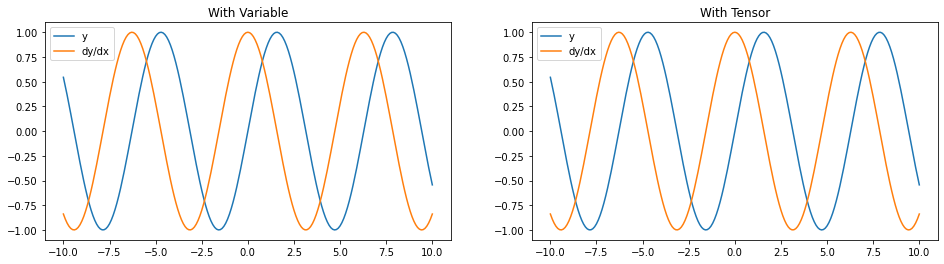

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
ax1.plot(x, y, label='y')
ax1.plot(x, dy_dx, label='dy/dx')
ax1.set_title("With Variable")
ax2.plot(x_t, y_t, label='y')
ax2.plot(x_t, dy_dx_t, label='dy/dx')
ax2.set_title("With Tensor")
ax1.legend()
ax2.legend()
plt.show()

# Models <a class="anchor" id="models"></a>
### Utils <a class="anchor" id="utils"></a>

In [9]:
# Data generation parameters
W = 3
B = 2

# Data generation
def f_test(x):
  return x * W + B

def generate_reg_data():
  x = tf.linspace(-2,2, 401)
  x = tf.cast(x, tf.float32)
  noise = tf.random.normal(shape=[len(x)])
  y = f_test(x) + noise
  return x, y

# Plotting functions
def plot_reg(x, y, f=None, model=None):
  plt.figure(figsize=(10,5))
  plt.plot(x, y, '.', label="Data")
  if f !=None:
    plt.plot(x, f(x), label="Ground truth")
  if model!=None:
    plt.plot(x, model(x), label="Predictions")
  plt.legend()
  plt.show()

def plot_w_b_evol(ws, bs):
  plt.figure(figsize=(10,5))
  plt.plot(ws, label='Weights', c="b")
  plt.plot([W] * len(ws), '--', label = "True weight", c="b")
  plt.plot(bs, label='bias', c="r")
  plt.plot([B] * len(bs), "--",label="True bias", c="r")
  plt.legend()
  plt.show()

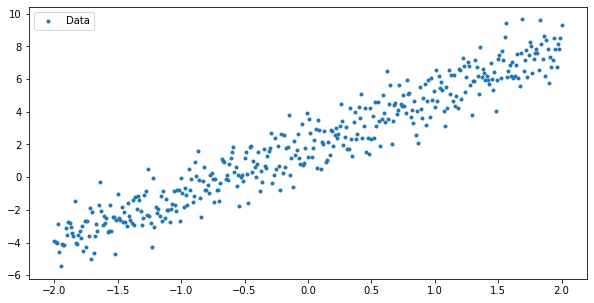

In [10]:
# Generated data for training
x, y = generate_reg_data()
plot_reg(x,y)

## TF.Module <a class="anchor" id="tfmod"></a>
#### Model <a class="anchor" id="tfm_mod"></a>

In [11]:
# Model definition : initial parameters + forward function
class MyModel(tf.Module):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    np.random.seed(7) # Fixed seed for reproductability
    self.w = tf.Variable(np.random.normal(), name="w")
    self.b = tf.Variable(0.0, name="b")

  def __call__(self, x):
    return self.w * x + self.b

#### Training functions <a class="anchor" id="tfm_func"></a>

In [12]:
def loss(target_y, predicted_y):
  # MSE
  return tf.reduce_mean(tf.square(target_y - predicted_y))

@tf.function # Allows for faster computation
def train(model, x, y, learning_rate):
  with tf.GradientTape() as t:
    # Trainable variables are automatically tracked by GradientTape
    current_loss = loss(y, model(x))

  # Use GradientTape to calculate the gradients with respect to W and b
  dw, db = t.gradient(current_loss, [model.w, model.b])
  # dw, db = t.gradient(current_loss, model.trainable_variables) # Same 
  # Subtract the gradient scaled by the learning rate
  model.w.assign_sub(learning_rate * dw)
  model.b.assign_sub(learning_rate * db)

def report(model, loss):
  # Model's info
  return f"W = {model.w.numpy():1.2f}, b = {model.b.numpy():1.2f}, loss={loss:2.5f}"

def training_loop(model, x, y, epochs):
  # Collect the history of W-values and b-values to plot later
  weights = [model.w.numpy()]
  biases = [model.b.numpy()]
  for epoch in range(epochs):
    # Update the model with the single giant batch
    train(model, x, y, learning_rate=0.1)
    weights.append(model.w.numpy())
    biases.append(model.b.numpy())
    current_loss = loss(y, model(x))
    print(f"Epoch {epoch}: ")
    print("    ", report(model, current_loss))

  return weights, biases

#### Train <a class="anchor" id="tfm_train"></a>

In [13]:
# Initialisation
model = MyModel()
# List variables and their initial values
print(f"Model's Variables:\n {model.variables}")
print(f"Model's Trainable variables:\n {model.trainable_variables}")

Model's Variables:
 (<tf.Variable 'b:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'w:0' shape=() dtype=float32, numpy=1.6905257>)
Model's Trainable variables:
 (<tf.Variable 'b:0' shape=() dtype=float32, numpy=0.0>, <tf.Variable 'w:0' shape=() dtype=float32, numpy=1.6905257>)


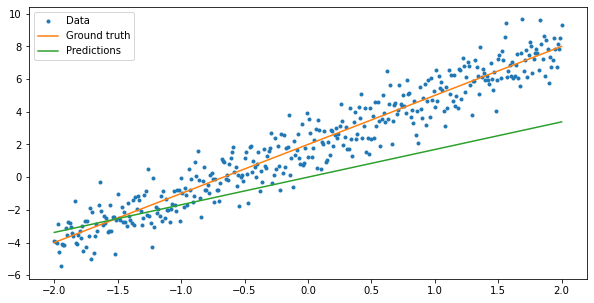

Initial state : W = 1.69, b = 0.00, loss=7.19335


In [16]:
# Initial prediction with random coef
plot_reg(x, y, f_test, model)
print(f"Initial state : {report(model, loss(y, model(x)).numpy())}")

In [17]:
# Training
ws, bs = training_loop(model, x, y, 10)

Epoch 0: 
     W = 2.05, b = 0.39, loss=4.69663
Epoch 1: 
     W = 2.31, b = 0.71, loss=3.21382
Epoch 2: 
     W = 2.50, b = 0.96, loss=2.32650
Epoch 3: 
     W = 2.64, b = 1.16, loss=1.79165
Epoch 4: 
     W = 2.74, b = 1.32, loss=1.46706
Epoch 5: 
     W = 2.82, b = 1.45, loss=1.26881
Epoch 6: 
     W = 2.87, b = 1.55, loss=1.14701
Epoch 7: 
     W = 2.91, b = 1.64, loss=1.07178
Epoch 8: 
     W = 2.94, b = 1.70, loss=1.02510
Epoch 9: 
     W = 2.96, b = 1.76, loss=0.99600


Prediction after training


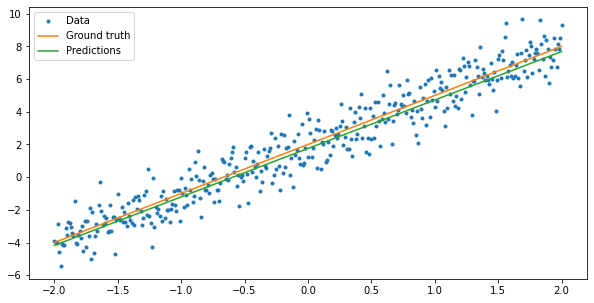

Variables value evolution


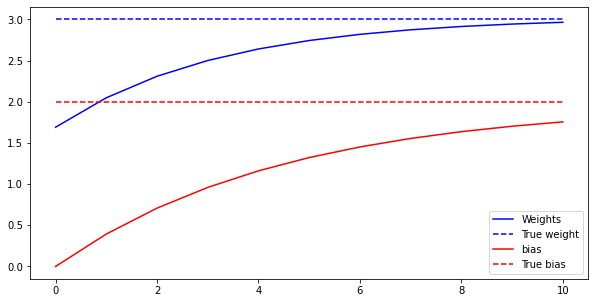

In [18]:
# Prediction
print("Prediction after training")
plot_reg(x, y, f_test, model)
print("Variables value evolution")
plot_w_b_evol(ws, bs)

## Keras <a class="anchor" id="keras"></a>
#### Model <a class="anchor" id="keras_mod"></a>

In [23]:
# Same as previously with keras.Model inplace of tf.Module.
# Keras allows easy training of the model
class MyModelKeras(keras.Model):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    np.random.seed(7)
    self.w = tf.Variable(np.random.normal(), name="w")
    self.b = tf.Variable(0.0, name="b")

  def call(self, x): # Keras will interpret call as __call__
    return self.w * x + self.b

In [24]:
# Model Initialisation
keras_model = MyModelKeras()
# Compile model : choose optimizer and loss function (and metrics)
keras_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.1),
    loss=keras.losses.mean_squared_error,
)
# Model info
print(f"Initial state : {report(keras_model, loss(y, keras_model(x)).numpy())}")

Initial state : W = 1.69, b = 0.00, loss=7.19335


#### Train <a class="anchor" id="keras_train"></a>

In [25]:
# For each epoch, data is passed to the model in batch of size batch_size. Default is 32.
# Since we have 401 points, batch_size=1000 allows the same behavior as previously. (batch_size=401 would have done the same)
k_m_hist = keras_model.fit(x, y, epochs=10, batch_size=1000)
# Loss printed before train

Epoch 1/10
1/1 [==============================] - 0s 356ms/step - loss: 7.1933
Epoch 2/10
1/1 [==============================] - 0s 4ms/step - loss: 4.6966
Epoch 3/10
1/1 [==============================] - 0s 3ms/step - loss: 3.2138
Epoch 4/10
1/1 [==============================] - 0s 4ms/step - loss: 2.3265
Epoch 5/10
1/1 [==============================] - 0s 5ms/step - loss: 1.7917
Epoch 6/10
1/1 [==============================] - 0s 7ms/step - loss: 1.4671
Epoch 7/10
1/1 [==============================] - 0s 6ms/step - loss: 1.2688
Epoch 8/10
1/1 [==============================] - 0s 4ms/step - loss: 1.1470
Epoch 9/10
1/1 [==============================] - 0s 4ms/step - loss: 1.0718
Epoch 10/10
1/1 [==============================] - 0s 4ms/step - loss: 1.0251


Final state : W = 2.96, b = 1.76, loss=0.99600


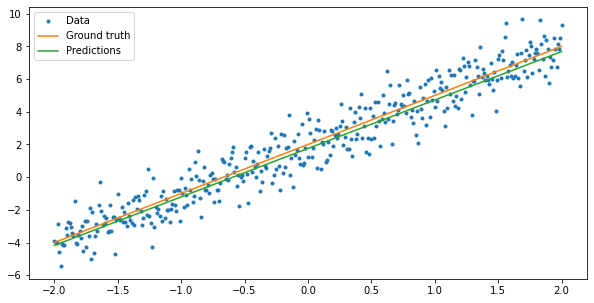

In [26]:
print(f"Final state : {report(keras_model, loss(y, keras_model(x)).numpy())}")
plot_reg(x, y, f_test, keras_model)

Same results.

## Keras Sequential <a class="anchor" id="keras_seq"></a>
#### Model <a class="anchor" id="kseq_mod"></a>

In [28]:
def report_seq(model_seq, loss):
    # Model info
    [w, b] = model_seq.layers[0].weights
    return f"W = {w.numpy()}, b = {b.numpy()}, loss={loss:2.5f}"

In [32]:
# Sequential API allows easy and fast implementation of the model by ordering layers freely
keras_seq_model = keras.Sequential(
    [
        layers.Dense(1, activation="linear") # 1 Neuron ie w * x + b as previously
    ]
)
# Compile model
keras_seq_model.compile(
    optimizer=keras.optimizers.SGD(learning_rate=0.1),
    loss=keras.losses.mean_squared_error,
)

# Sequential model needs data to be in shape (batch_size, input_dim) so we reshape x in (401,1)
# Output data will also be in that shape
x_seq = tf.reshape(x, (-1,1))
y_seq = tf.reshape(y, (-1,1))

# Model info
print(f"Initial state : {report_seq(keras_seq_model, loss(y_seq, keras_seq_model(x_seq)).numpy())}")

Initial state : W = [[1.0678037]], b = [0.], loss=9.93721


#### Train <a class="anchor" id="kseq_train"></a>

In [33]:
# Training
ksm_hist = keras_seq_model.fit(x_seq, y_seq, epochs=10, batch_size=1000)

Epoch 1/10
1/1 [==============================] - 1s 706ms/step - loss: 9.9372
Epoch 2/10
1/1 [==============================] - 0s 4ms/step - loss: 6.1669
Epoch 3/10
1/1 [==============================] - 0s 6ms/step - loss: 4.0016
Epoch 4/10
1/1 [==============================] - 0s 5ms/step - loss: 2.7486
Epoch 5/10
1/1 [==============================] - 0s 4ms/step - loss: 2.0178
Epoch 6/10
1/1 [==============================] - 0s 5ms/step - loss: 1.5883
Epoch 7/10
1/1 [==============================] - 0s 7ms/step - loss: 1.3337
Epoch 8/10
1/1 [==============================] - 0s 5ms/step - loss: 1.1818
Epoch 9/10
1/1 [==============================] - 0s 8ms/step - loss: 1.0904
Epoch 10/10
1/1 [==============================] - 0s 6ms/step - loss: 1.0351


Final state : W = [[2.9369144]], b = [1.7551843], loss=1.00135


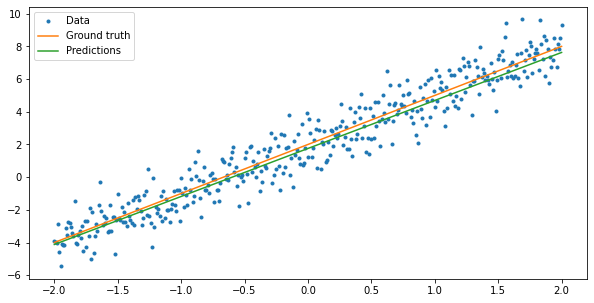

In [34]:
print(f"Final state : {report_seq(keras_seq_model, loss(y_seq, keras_seq_model(x_seq)).numpy())}")
plot_reg(x,y,f_test,keras_seq_model)

Same results.